In [559]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error




# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bengaluru-house-price-data/Bengaluru_House_Data.csv


In [560]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("amitabhajoy/bengaluru-house-price-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/bengaluru-house-price-data


In [561]:
house_data = pd.read_csv("/kaggle/input/bengaluru-house-price-data/Bengaluru_House_Data.csv")

In [562]:
house_data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [563]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [564]:
house_data.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [565]:
house_data.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [566]:
house = house_data.drop(['availability' , 'society' , 'area_type' , 'balcony'] 
                        , axis = 'columns')
house.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


**Missing Attributes**

In [567]:
house.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [568]:
home = house.dropna()
home.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [569]:
home['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [570]:
home['bhk']=home['size'].apply(lambda x : int(x.split(' ')[0]))

/tmp/ipykernel_36/3483640689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home['bhk']=home['size'].apply(lambda x : int(x.split(' ')[0]))


In [571]:
home.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [572]:
home['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [573]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [574]:
home[~home['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [575]:
def convert_sqft_to_nums(x):
    tokens= x.split('-')
    if len(tokens)==2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [576]:
convert_sqft_to_nums('2350 - 4000')

3175.0

In [577]:
df = home.copy()
df['total_sqft']= df['total_sqft'].apply(convert_sqft_to_nums)
df.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [578]:
home5 = df.copy()
home5['price_per_sqft']=home5['price']*100000/home5['total_sqft']
home5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [579]:
home5.location = home5.location.apply(lambda x : x.strip())
location_stats = home5.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats.head()

location
Whitefield         535
Sarjapur  Road     392
Electronic City    304
Kanakpura Road     266
Thanisandra        236
Name: location, dtype: int64

In [580]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
Basapura                 10
1st Block Koramangala    10
Gunjur Palya             10
Kalkere                  10
Sector 1 HSR Layout      10
                         ..
1 Giri Nagar              1
Kanakapura Road,          1
Kanakapura main  Road     1
Karnataka Shabarimala     1
whitefiled                1
Name: location, Length: 1052, dtype: int64

In [581]:
len(home5.location.unique())

1293

In [582]:
home5.location = home5.location.apply(lambda x :  'others' if x in location_stats_less_than_10 else x)
len(home5.location.unique())

242

array([[<Axes: title={'center': 'total_sqft'}>,
        <Axes: title={'center': 'bath'}>],
       [<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'bhk'}>],
       [<Axes: title={'center': 'price_per_sqft'}>, <Axes: >]],
      dtype=object)

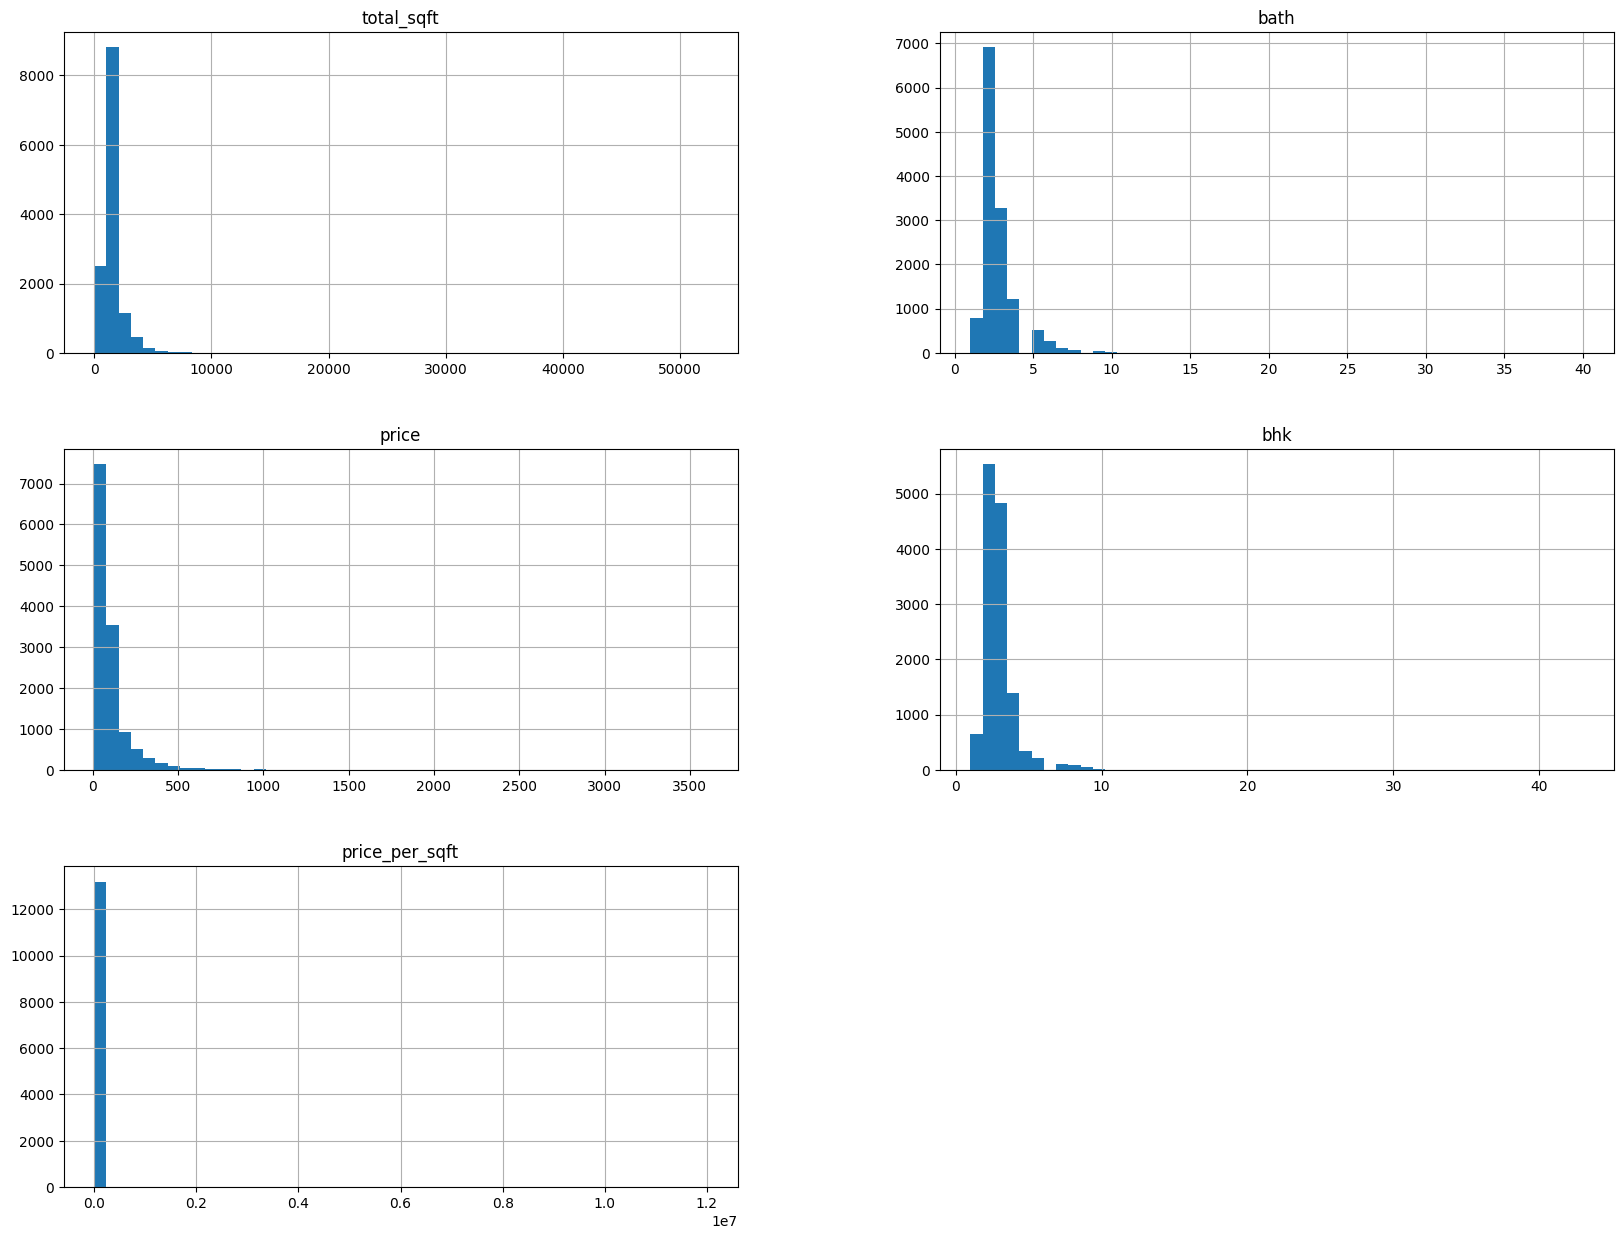

In [583]:
home5.hist(bins = 50 , figsize=(20,15))

**TAIN-TEST SPLITTING**

In [584]:
def split_train_test(data , test_ratio):
    shuffled = np.random.permutation(len(data))
    np.random.seed(42)
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled[:test_set_size]
    train_indices = shuffled[test_set_size :]
    return data.iloc[train_indices] , data.iloc[test_indices]

In [585]:
train_set , test_set = split_train_test(home5 , 0.2)
print("the length of train set is : " , len(train_set))
print("the length of test set is : " , len(test_set))

the length of train set is :  10597
the length of test set is :  2649


In [586]:
train_set,test_set = train_test_split(home5 , test_size = 0.2 , random_state = 42)
print("the length of train set is : " , len(train_set))
print("the length of test set is : " , len(test_set))

the length of train set is :  10596
the length of test set is :  2650


In [587]:
home5 = train_set.copy()

**Correlation Matrix**

In [588]:
corr_matrix = home5.select_dtypes(include=[np.number]).corr()
#Use only numeric columns for correlation


In [589]:
corr_matrix['price'].sort_values(ascending = False)

price             1.000000
total_sqft        0.558691
bath              0.450879
bhk               0.389807
price_per_sqft    0.122251
Name: price, dtype: float64

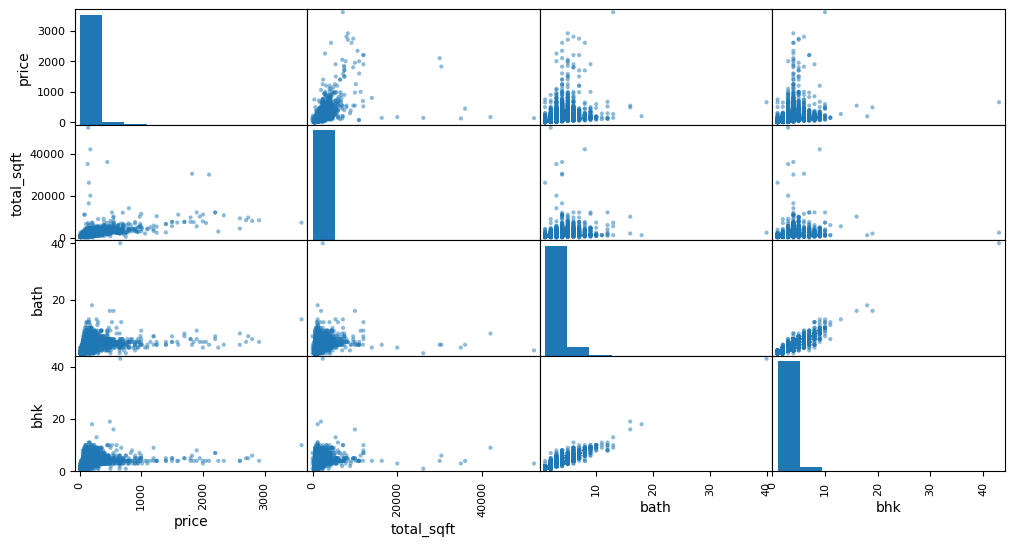

In [590]:
attributes = ["price" , "total_sqft", "bath", "bhk" ]
scatter_matrix(home5[attributes], figsize=(12, 6))
plt.show()

<Axes: xlabel='total_sqft', ylabel='price'>

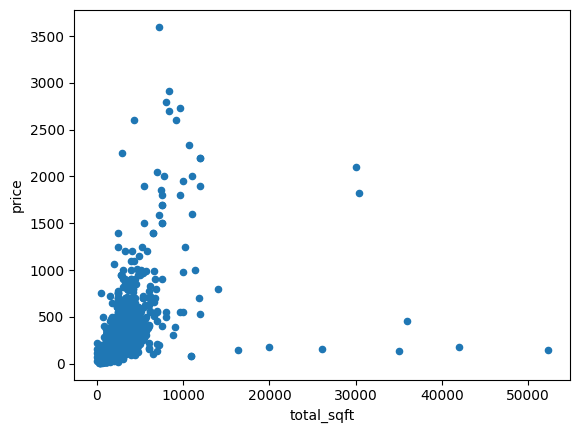

In [591]:
home5.plot(kind = "scatter" , x = "total_sqft" , y = "price")

In [592]:
home5 = train_set.drop("price" , axis = 1)
home5_labels = train_set["price"].copy()

In [593]:
my_pipeline = Pipeline([
    ('imputer' , SimpleImputer(strategy = "median")),
    ('std_scaler' , StandardScaler()),
    
])

**Scikit-Learn Design**

In [594]:
housing_num = home5.select_dtypes(include=[np.number])
housing_num_tr = my_pipeline.fit_transform(housing_num)


In [595]:
housing_num_tr

array([[-0.40933453, -0.51916708, -0.62160716, -0.0730281 ],
       [ 0.98399119,  1.71402414,  0.91910617,  0.06880167],
       [-0.22218278, -0.51916708,  0.1487495 , -0.11065195],
       ...,
       [ 0.64100695,  0.22522999,  0.1487495 , -0.13838257],
       [-0.16718308, -0.51916708, -0.62160716, -0.06556752],
       [-0.23440493, -0.51916708, -0.62160716, -0.13508359]])

**Selecting a desired model for bangalore house prediction**

In [596]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(housing_num_tr, home5_labels)


RandomForestRegressor()

In [597]:
some_data = housing_num.iloc[:5]



In [598]:
some_labels = home5_labels.iloc[:5]

In [599]:
prepared_data = my_pipeline.transform(some_data)

In [600]:
model.predict(prepared_data)

array([ 54.082 , 251.47  ,  55.2075, 229.32  , 484.53  ])

In [601]:
list(some_labels)

[54.1, 250.0, 55.25, 230.0, 485.0]

**Evaluating the Model**

In [602]:
housing_prediction = model.predict(housing_num_tr)
lin_mse = mean_squared_error(home5_labels , housing_prediction)
lin_rmse = np.sqrt(lin_mse)

In [603]:
lin_rmse

10.667164815575562

**For Better Evaluation we use Cross Validation**

In [604]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, housing_num_tr, home5_labels,
                         scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

print("Cross-validated RMSE:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Standard deviation:", rmse_scores.std())


Cross-validated RMSE: [18.01653414 29.70014996 15.65682806 50.68890108 12.08513081 12.72996777
 36.27346402 51.62436935 15.74077169 16.03023004]
Mean RMSE: 25.85463469254612
Standard deviation: 14.595397748558259


*Random Forest =
Cross-validated RMSE: [15.14481013 30.90719524 14.93410551 51.15038247 11.14878367 14.03169625
 35.92016447 50.99221465 16.54220221 15.26167348]
 
Mean RMSE: 25.60332280776966

Standard deviation: 14.788234905008908*

**Decision Tree = 
Cross-validated RMSE: [21.32520681 26.80478125 24.9403162  51.81574744 10.75658727 23.43729229
 42.1840144  55.34802763 22.18413075 22.43463525]

 Mean RMSE: 30.123073929208942
Standard deviation: 13.818504108786929
 **
*Linear Regression =
Cross-validated RMSE: [115.34359132 155.31904327 112.38527143 158.37735035  84.55027171
 108.32560214 148.62902622 258.0247958  107.77932993 118.50210401]
Mean RMSE: 136.72363861753297
Standard deviation: 46.27974703129453*
 

In [605]:
from joblib import dump , load
dump(model , 'BHPP.joblib')

['BHPP.joblib']

In [606]:
# Step 1: Drop target column and copy labels
X_test = test_set.drop("price", axis=1)
y_test = test_set["price"].copy()

# Step 2: Select only numeric features (same as during training)
X_test_num = X_test.select_dtypes(include=[np.number])

# Step 3: Transform numeric features using the pipeline
X_test_prep = my_pipeline.transform(X_test_num)

# Step 4: Make predictions and evaluate
final_predictions = model.predict(X_test_prep)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print("Final RMSE on test set:", final_rmse)

Final RMSE on test set: 9.844622409988007


In [608]:
print(final_predictions , list(Y_test))

64       140.00
1962      45.95
8530      85.00
7295      65.00
2789      97.00
          ...  
4981      37.00
9051      75.00
11780     24.95
9881      70.00
10189    135.00
Name: price, Length: 2650, dtype: float64